# Predicting Credit Card Defaults

#### _Jeremy Locatelli, Erik Ring-Walters, Andrea Cano_
***

# Introduction
* This markdown is going to explore the data of a credit card csv. The data provides details on a subjects spousal information, age, education, sex, balance, payments, and whether they have defaulted. Using these categories we hope to predict what influences an individual to default. Using multiple algorithms to find the best predictors we will try and visualize the accuracy

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
dat = pd.read_csv('default_cc_train.csv')
dat.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

***
## Data Exploration

* To start we generally explore the data to find what initial observations would be, spot any abnormalities and fix any possible nulls or odd values within the dataset.

In [3]:
sns.set_style("whitegrid");

* The countplot below shows the initial amount of subjects in the dataset who have or have not defaulted. According to the plot, Defaulting, which is represented by the number 1, is not an overwhelming occurrence. 

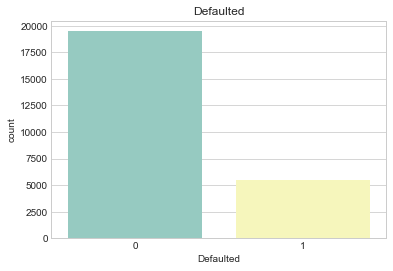

In [4]:
sns.countplot("default.payment.next.month", data=dat,palette="Set3")
plt.title("Defaulted")
plt.xlabel("Defaulted");

* This next countplot, also shows those who have defaulted but now it is separated by sex. Sex is represented with 1 being Male and the color Green and 2 being Female and the color yellow. It doesn't seem that sex has an overpowering influence but it is interesting to see the difference in the amount of females vs males. From the graph, not only does it show that females were most likely not to default it also shows that they defaulted more than males. Is this because there are more females in this set or could it be because of something else?

Number of Males:  9891
Number of Females:  15109


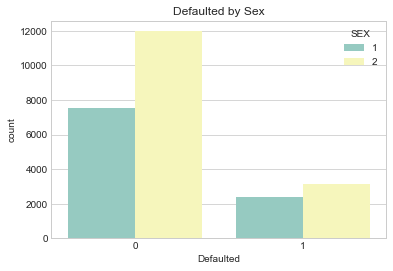

In [5]:
sns.countplot("default.payment.next.month", data=dat, hue="SEX",palette="Set3")
plt.title("Defaulted by Sex")
plt.xlabel("Defaulted");

print("Number of Males: ", sum(dat["SEX"]==1))
print("Number of Females: ", sum(dat["SEX"]==2))

* The next option to look at is AGE. The ages are widely spread throughout the data, but according to the density curve we have a lot of ages peaking at the late twenties. Most likely due to college fees or recent graduates, that most credit card companies target. 

C:\Users\Andrea\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


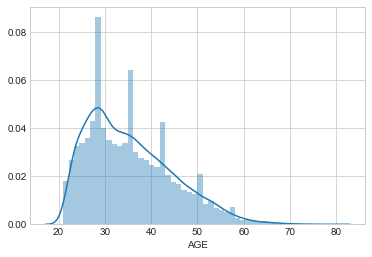

In [6]:
sns.distplot(dat.AGE);

* So because AGE has a distinctive area of population, a violin plot will show just how many have defaulted in an age range. And from the plot, it is noticeably wider between the ages of 20-30. However, each violin has a similar shape and median when it comes to defaulting. The only major difference is the fact that around age 35 there is a higher chance to default. 

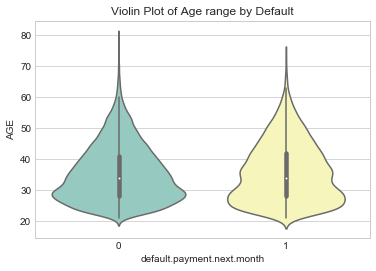

In [7]:
sns.violinplot("default.payment.next.month","AGE", data=dat, palette="Set3")
plt.title("Violin Plot of Age range by Default");

* Marriage is another category to look at. According to the dataset; 1 stands for married, 2 stands for single, and 3 stands for others. However, 0 is also included in this barplot. But because there is no definition for this value it is assumed to be a placeholder. This is something that should be dropped and dealt with in the preprocessing. Because the 0 values will be dropped from further explorations, the rest of this description of the graph will take it out of consideration.

* The barplot shows that around 26% of married males defaulted where as 22% of married females defaulted. The black lines show a margin of error which is understandable as to why it is so long in the "others" category for both males and females. 

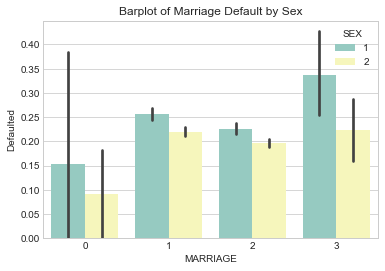

In [8]:
sns.barplot(x="MARRIAGE",y="default.payment.next.month", hue="SEX", data=dat, palette="Set3")
plt.title("Barplot of Marriage Default by Sex")
plt.ylabel("Defaulted");

* Next is defaulting based off of education. According to the dataset, 1 means Graduate School, 2 means University, 3 means Highschool, and 0,4,5,6 are all categorized as others. This is another instance where preprocessing comes into play. So instead of removing the categories they will be merged into a single category known as other.

* With the preprocessing in mind, another look at the graph shows that those who are in University are the most and least likely to default on payments. This is interesting since for each level of education it is a low chance for defaulting compared to not defaulting. 

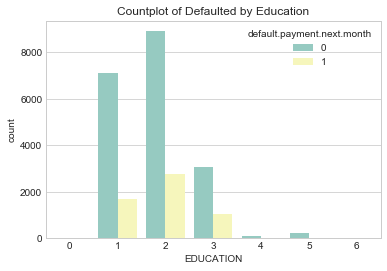

In [9]:
edu = sns.countplot(x="EDUCATION", hue="default.payment.next.month", data=dat, palette="Set3")
plt.title("Countplot of Defaulted by Education");

* Last plot to look at is a boxplot for the first Pay period in September 2005, The pay history is categorized where -2 is no consumption, -1 is paid in full, 0 is the use of revolving credit, and 1-8 are payments delayed by that number of months. 

* So looking at this plot we notice that Defaulting was a popular occurrence after a payment was delayed after 1 month. 


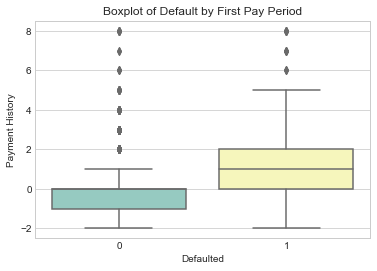

In [10]:
sns.boxplot("default.payment.next.month", "PAY_0",data = dat, palette = "Set3")
plt.title("Boxplot of Default by First Pay Period")
plt.xlabel("Defaulted")
plt.ylabel("Payment History");

## Preprocessing

* As discussed above, some preprocessing needed was in the Marriage and Education tabs. To correct these inconsistencies we used two different techniques. 

* First for the Marriage section, the 0 column was removed entirely because it did not represent any information in the dataset. 

* Then for Education, since columns 0,4,5,6 all stood for "other", replace was used to combine all those columns into a single "other" option which was placed in the number 4 column.


In [11]:
#Getting rid of 0's in Marriage
dat = dat[dat.MARRIAGE != 0]



#getting rid of 0,5,6 in Education
for i in [0,5,6]:
    dat.EDUCATION.replace(i,4)

    
#Scale data 
    
    

***
## Classifiers
### SVM 

* To begin explaining the Support Vector Machine, the first step is to split the data into training and test sets along with separating are target from our training data. Because our outcome is to predict whether someone will default or not, the target will be "default.payment.next.month" and our X will be everything but that column. 

* Using the SVC function imported though sklearn.svm, on the whole dataset without moderation, the accuracy is approximately 78% this is the  baseline of what the future algorithms should surpass.

In [12]:
X = dat.loc[:, dat.columns != "default.payment.next.month"]
y  = dat.iloc[:,24]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)


svm = SVC()

# Training and predictions SVC
svm.fit(X_train,y_train)
predicts = svm.predict(X_test)
accuracy = accuracy_score(y_test,predicts)
print("The accuracy of our Support Vector Classifier is: " + str(accuracy))

#next Scale data and rerun

The accuracy of our Support Vector Classifier is: 0.7757134183363692
